# **Описание проекта**

**Сайт запустил A/B-тест с целью увеличения дохода. Файл CSV содержит исходные данные о результатах эксперимента (user_id), типе выборки (variant_name) и доходе, полученном пользователем (revenue).**

**Задача состоит в том, чтобы проанализировать результаты эксперимента.**

# **Процесс тестирования AB**

---


**1.Понимание бизнес-проблем**

**2.Обнаружить и устранить проблемы в данных (пропущенное значение, выбросы, неожиданное значение)**

**3.Посмотреть сводную статистику и графики**

**4.Произвести проверку гипотез**

**5.Проверить нормальность и однородность распределения данных**

**6.Применить статистические тесты (тест Шапиро, тест Левена, T-тест, тест Уэлча, U-тест Манна Уитни)**

**7.Оценить результаты**

**8.Сделать выводы**

**9.Сделать отчёт и поделиться с коллегами**

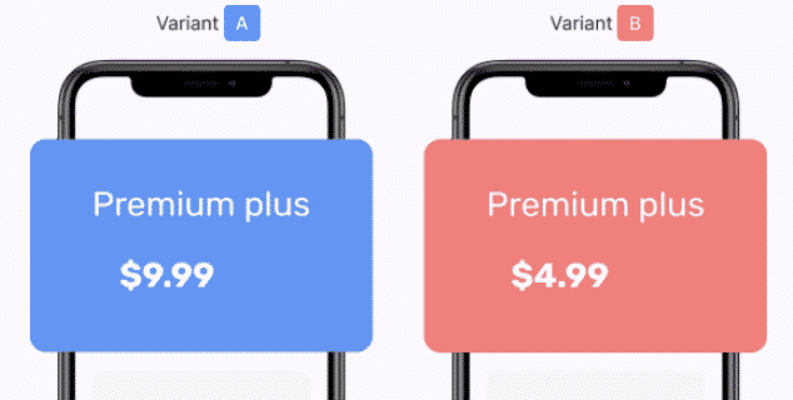

# **Импорт библиотек и знакомство с данными**

---



---



---



In [39]:
import os
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal, normaltest
from statsmodels.stats.proportion import proportions_ztest
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.read_csv('/content/drive/MyDrive/DataSets/AB_Test_Results.csv')

In [40]:
def check_df(dataframe, head=5):
    print(" ФОРМА ТАБЛИЦЫ ".center(70,'-'))
    print('Строки: {}'.format(dataframe.shape[0]))
    print('Столбцы: {}'.format(dataframe.shape[1]))
    print(" Типы ".center(70,'-'))
    print(dataframe.dtypes)
    
    print(" Первые 5 строк ".center(70,'-'))
    print(dataframe.head(head))
    print(" Последние 5 строк ".center(70,'-'))
    print(dataframe.tail(head))
    
    print(" Пропущенных значений ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" Дублирующих значений ".center(70,'-'))
    print(dataframe.duplicated().sum())
    
    print(" Описательная статистика ".center(70,'-'))
    print(dataframe.describe([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]).T)
    
check_df(df)

--------------------------- ФОРМА ТАБЛИЦЫ ----------------------------
Строки: 10000
Столбцы: 3
-------------------------------- Типы --------------------------------
USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object
--------------------------- Первые 5 строк ---------------------------
   USER_ID VARIANT_NAME  REVENUE
0      737      variant    0.000
1     2423      control    0.000
2     9411      control    0.000
3     7311      control    0.000
4     6174      variant    0.000
------------------------- Последние 5 строк --------------------------
      USER_ID VARIANT_NAME  REVENUE
9995     1981      control    0.000
9996      502      variant    0.000
9997     9214      variant    0.000
9998     7741      control    0.000
9999     9468      control    0.000
------------------------ Пропущенных значений ------------------------
USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64
------------------------ Дублирующих значений -------

# **Предварительная обработка данных**

---



---



---



**Приведём название столбцов к нижнему регистру**

In [41]:
df.columns = map(str.lower, df.columns)

**Удалим пользователей которые попали в обе группы**

In [42]:
duplicates = (df.groupby("user_id")["variant_name"].nunique() == 1)
duplicates = duplicates[duplicates]
df = df[df["user_id"].isin(duplicates.index)]
print(" DESCRIBE ".center(70,'-'))
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["revenue"]].T

------------------------------ DESCRIBE ------------------------------


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
revenue,6070.000,0.107,2.674,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.160,196.010


#**Сводная статистика и графики**

---



---



---



---



**Сводная статистика групп A/B**

In [43]:
df.groupby(by='variant_name').agg({'user_id': 'nunique',
                                               'revenue': ['sum', 'mean', 'median', 'count']})

user_id revenue                   
             nunique     sum  mean median count
variant_name                                   
control         2390 470.560 0.156  0.000  3026
variant         2393 179.320 0.059  0.000  3044

**Сводная статистика групп A/B**

In [44]:
df.groupby("user_id")['revenue'].agg(["count", "median", "mean", "std", "max", 'sum']).sort_values(by='sum', ascending=False)

,count,median,mean,std,max,sum
user_id,,,,,,
3342,1,196.010,196.010,NaN,196.010,196.010
2166,2,14.660,14.660,20.732,29.320,29.320
7356,1,23.040,23.040,NaN,23.040,23.040
1053,4,0.000,5.018,10.035,20.070,20.070
3684,1,19.470,19.470,NaN,19.470,19.470
...,...,...,...,...,...,...
3363,1,0.000,0.000,NaN,0.000,0.000
3362,1,0.000,0.000,NaN,0.000,0.000
3361,1,0.000,0.000,NaN,0.000,0.000


**Доверительный интервал для значения "ВЫРУЧКА"?**

In [45]:
sms.DescrStatsW(df["revenue"]).tconfint_mean()

(0.039794372950474055, 0.17433412787324915)

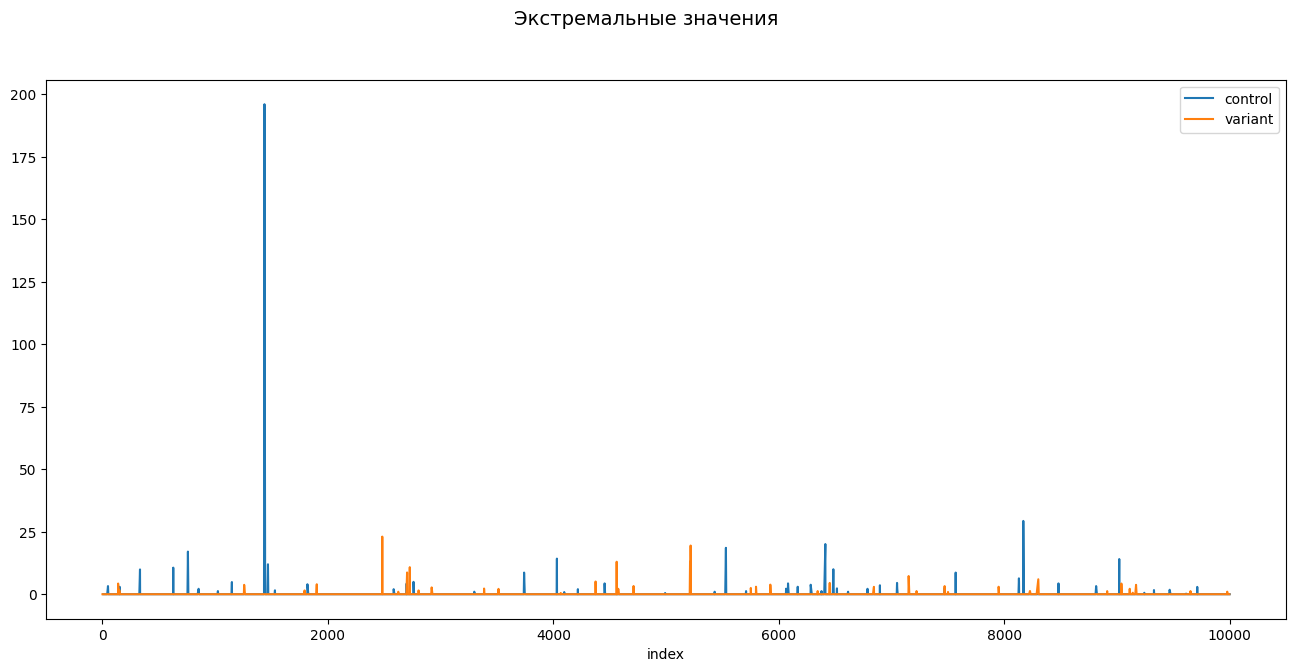

In [46]:
df[df['variant_name'] == "control"].reset_index().set_index("index")['revenue'].plot(legend = True, label = "control", figsize = (16,7))

df[df['variant_name'] == "variant"].reset_index().set_index("index")['revenue'].plot(legend = True, label = "variant")

plt.suptitle("Экстремальные значения", fontsize = 14);

**Уберем любые несоответствующие ценности, для дальнейшей обработки**

In [47]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit.round(), up_limit.round()
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
replace_with_thresholds(df, "revenue")

**Доверительный интервал для "ВЫРУЧКИ" после удаление экстремальных значений**

In [48]:
sms.DescrStatsW(df["revenue"]).tconfint_mean()

(0.03595388879674289, 0.05730476029716155)

**После удаления экстремальных значений**

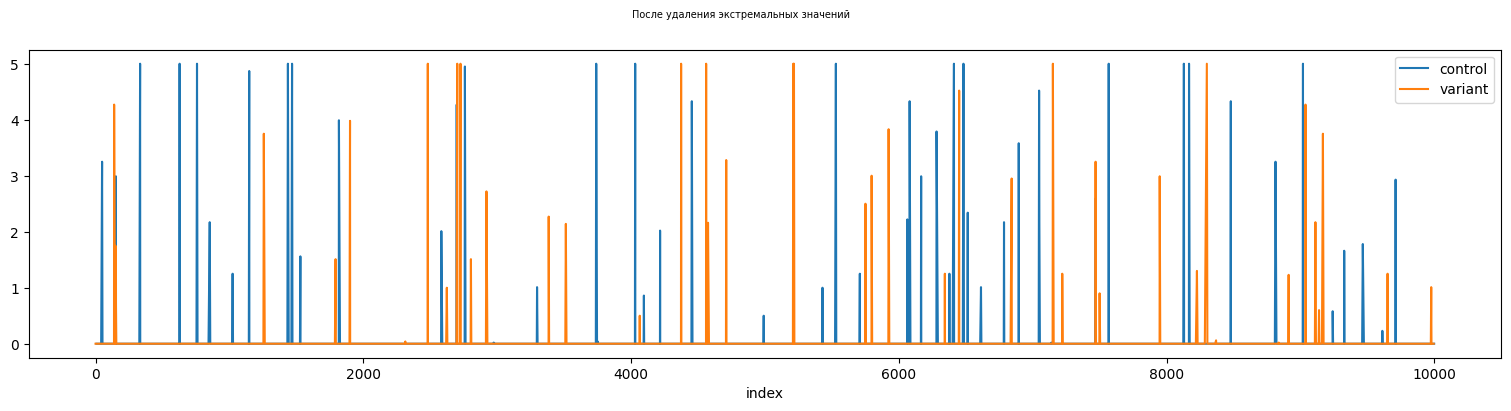

In [49]:
df[df['variant_name'] == "control"].reset_index().set_index("index")['revenue'].plot(legend = True, label = "control", figsize = (19,4))
df[df['variant_name'] == "variant"].reset_index().set_index("index")['revenue'].plot(legend = True, label = "variant")
plt.suptitle("После удаления экстремальных значений", fontsize = 7);

# **Проверка гипотез**

---



---



---



**H0: Данные имеют нормальное распределение**

**H1: Данные имеют ненормальное распределение**

In [50]:
df.groupby('variant_name').agg({'revenue': ['sum', 'count']}).reset_index()

variant_name revenue      
                   sum count
0      control 165.060  3026
1      variant 117.980  3044

# **A/B тестирование:**

*   **Проверить нормальность**
*   **Если распределение нормальное, проверьте однородность**
*   **Разделить и определить контрольную группу и тестовую группу**
*   **Примените тест Шапиро на нормальность**
*   **Если параметрический, применитm тест Левена на однородность отклонений**
*   **Если параметрические + однородность отклонений, примените T-критерий**
*   **При параметрической однородности отклонений применить тест Уэлча**
*   **Если непараметрический, примените U-тест Манна Уитни напрямую**










In [51]:
def AB_Test(dataframe, group, target, A, B):
    
    # Импорт библиотек
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Разделение A/B
    groupA = dataframe[dataframe[group] == A][target]
    groupB = dataframe[dataframe[group] == B][target]
    
    # Предположение: Нормальность
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Распределение нормальное! - False
    # H1: Распределение ненормальное! - True
    
    if (ntA == False) & (ntB == False): # "H0: Нормальное распределение"
         # Параметрический тест
         # Предположение: Однородность отклонений
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Однородность: False
        # H1: Гетерогенный: True
        
        if leveneTest == False:
            # Однородность
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - Ложная
            # H1: M1 != M2 - True
        else:
            # Разнородный
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Непараметрический тест
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Результат
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Столбцы
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Вывод гипотезы
    print("# A/B Проверка гипотезы")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

# **A/B тестирование:**

In [52]:
AB_Test(dataframe=df, group="variant_name", target="revenue", A='control', B='variant')

# A/B Проверка гипотезы
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.245,A/B groups are similar!


# **Выводы**

---



---



---



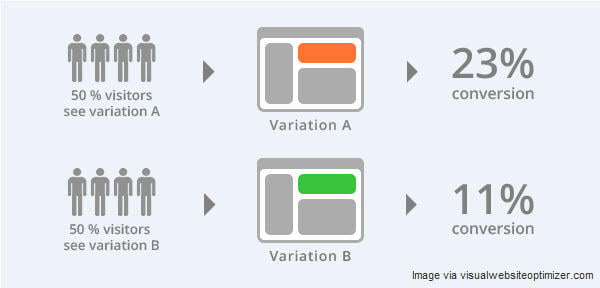


**Отвергает нулевую гипотезу, что А - Контрольная группа = В - экспериментально группе, так как P-value является меньше уровня значимости α = 0,05.**